In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
from functions.find_bubbles import *
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Redistributional consequences of asset price bubbles
*In other words: Who wins and who loses*

To find out, I simulate the model first.

In [2]:
NRUNS = 1
input_parameters = [0.29985649, 37.20189844, 74.72231157, 11.65898537,  0.73132061, 0.30623129,  0.57451773]
burn_in_period = 400 
labels = ['std_noise', 'w_fundamentalists', 'w_momentum', 'base_risk_aversion', "fundamentalist_horizon_multiplier",
                          "mutation_probability", "average_learning_ability"]

uncertain_parameters = dict(zip(labels, input_parameters))
params = {"ticks": 1200 + burn_in_period, "fundamental_value": 166, 'n_traders': 500, 'std_fundamental': 0.0530163128919286,
                  'spread_max': 0.004087, "w_random": 1.0, "init_stocks": 50, 'trader_sample_size': 19,
                  'horizon': 200, "trades_per_tick": 5}  # TODO make ticks: 600 * 10
params.update(uncertain_parameters)
#

In [3]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

('Start of simulation ', 0)


To study the redistributional effects of bubbles, I first find bubble periods.

In [4]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=burn_in_period)
y = pd.Series(mc_prices[0][:-1] / mc_fundamentals[0])

Text(0.5,0,'Simulation time')

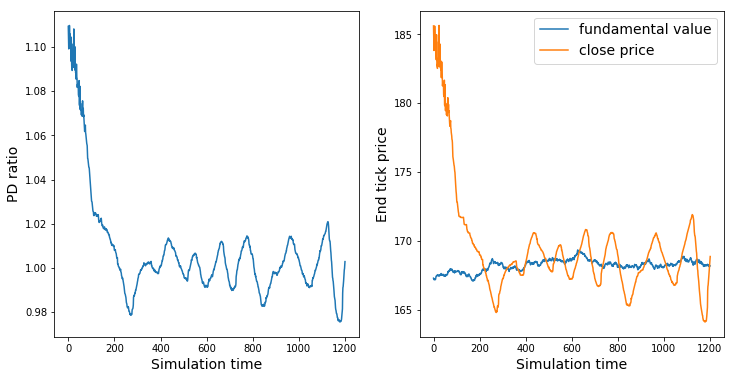

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

#ax1.plot(mc_returns.index, mc_returns[1], label='returns')
ax1.plot(y.index, y, label='returns')

ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('PD ratio', fontsize='14')

ax2.plot(mc_fundamentals.index, mc_fundamentals[0], label='fundamental value')
ax2.plot(mc_prices.index, mc_prices[0], label='close price')

ax2.set_ylabel('End tick price', fontsize='14')
ax2.legend(loc='best', fontsize='14')
ax2.set_xlabel('Simulation time', fontsize='14')

In [6]:
obs = len(y)
r0 = 0.01 + 1.8/np.sqrt(obs)
swindow0 = int(math.floor(r0*obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12*yr + swindow0 - 1
nboot = 99

bsadfs = PSY(y, swindow0, IC, adflag)
quantilesBsadf = cvPSYwmboot(y, swindow0, IC, adflag, Tb, nboot=99)

In [7]:
monitorDates = y.iloc[swindow0-1:obs].index
quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
ind95 =(bsadfs.T[0] > quantile95[1, ])
periods = monitorDates[ind95]
if True in ind95:
    bubbly_dates = find_sequences_ints(periods, monitorDates)
else:
    print('no bubbles')

In [8]:
def proper_bubbles(bubbly_dates):
    lenghts_of_bubbles = []
    for row in range(len(bubbly_dates)):
        lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)
    lenghts_of_bubbles = np.array(lenghts_of_bubbles)
    av_lenghts_of_bubbles = np.mean(lenghts_of_bubbles)
    long_bubble_condition = lenghts_of_bubbles > av_lenghts_of_bubbles
    r = np.array(range(len(long_bubble_condition)))
    locs_long_bubbles = r[long_bubble_condition]
    return locs_long_bubbles

In [9]:
proper_bubbles = bubbly_dates.iloc[proper_bubbles(bubbly_dates)]

In [10]:
start_dates = []
end_dates = []
bubble_types = []
for l in range(len(proper_bubbles)):
    start_dates.append(proper_bubbles.iloc[l]['start_date'])
    end_dates.append(proper_bubbles.iloc[l]['end_date'])

    if abs(y[end_dates[l]] - y[start_dates[l]]) > y[:end_dates[l]].std():
        # classify as boom or bust
        if y[start_dates[l]] > y[end_dates[l]]:
            bubble_type = 'bust'
        else:
            bubble_type = 'boom'
    else:
        if y[start_dates[l]:end_dates[l]].mean() > y[start_dates[l]]:
            # classify as boom-bust or bust-boom
            bubble_type = 'boom-bust'
        else:
            bubble_type = 'bust-boom'
    bubble_types.append(bubble_type)

In [11]:
bubble_types

['bust-boom',
 'boom-bust',
 'boom-bust',
 'bust-boom',
 'boom-bust',
 'bust-boom',
 'boom-bust',
 'bust-boom',
 'boom-bust',
 'bust-boom',
 'boom-bust',
 'bust-boom']

Then, I obtain data on agent-wealth and the following properties:



In [12]:
with open('all_many_bubbles_output.json', 'r') as f:
    bubble_data = json.loads(f.read())

In [13]:
runs = len(bubble_data)
runs

3

In [14]:
bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = [] 
horizons = [] 
learning_abilities = [] 
chartist_expectations = [] 
fundamentalist_expectations = []

for r in range(runs):
    if bubble_data[r][1]:
        bubble_types += bubble_data[r][0]#bubble_data[0][0] + bubble_data[1][0]
        bubble_prices += bubble_data[r][1]
        wealth_starts += bubble_data[r][2]
        wealth_ends += bubble_data[r][3]
        ginis_ot += bubble_data[r][4]
        palmas_ot += bubble_data[r][5]
        twtws_ot += bubble_data[r][6]
        risk_aversions += bubble_data[r][7]
        horizons += bubble_data[r][8]
        learning_abilities += bubble_data[r][9]
        chartist_expectations += bubble_data[r][10]
        fundamentalist_expectations += bubble_data[r][11]

In [15]:
unique_bubble_types = list(set(bubble_types))
unique_bubble_types

[u'boom-bust', u'bust-boom', u'boom', u'bust']

# Analyse:

Two approaches:

1. Take individual succes of agents and regress their attributes on profit differences: ToDo calculate wealth differences.

2. Compare ratio's of different groups before and after bubbles. 

In [16]:
bubble_types

[u'bust-boom',
 u'boom-bust',
 u'bust-boom',
 u'boom-bust',
 u'bust',
 u'boom',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'boom-bust',
 u'bust',
 u'boom',
 u'bust-boom']

In [21]:
# calc profits for the bubbles as the difference in wealth
profits = []
for idx, bubble in enumerate(bubble_types):
    profits.append(np.array(wealth_starts[idx]) - np.array(wealth_ends[idx]))

In [40]:
# regression model Y = profits
# regression model X = start_wealth, risk_aversions, horizons, learning_abilities, chartist_expectations, fundamentalist_expectations
len(twtws_ot)

13